# Market Impact Costs

The *standard mean-variance (Markowitz) portfolio selection model* determines an optimal investment portfolio that balances risk and expected return. In this notebook, we maximize the portfolio's expected return while constraining the admissible variance (risk) to a given maximum level. Please refer to the [annotated list of references](../literature.rst#portfolio-optimization) for more background information on portfolio optimization.

In this notebook, we consider a variant of this basic model in which we rebalance an existing portfolio while:
- accounting for *market impact costs*,
- enforcing minimum transaction sizes, and
- including a *risk-free asset*.

Transaction costs can be implicit or explicit.
Explicit or direct transaction costs are observable, directly charged to the investor, and can have a fixed component and a variable one proportional to the transaction volume.
Implicit or indirect costs, often called *market impact costs*, result from imperfect markets. For example, they may result from market or liquidity restrictions (e.g., bid-ask spreads) and depend on the order-book situation when an order is executed. They are not typically itemized explicitly (sometimes called hidden costs), and it can be difficult for investors to recognize them.

Market impact costs occur because the transaction changes the stock's market price.
They are defined as the difference between the transaction price and the (unperturbed) market price that would have prevailed if the trade had not occurred.
Market impact costs can be viewed as an additional fee for the immediate execution of large trades.
For large transactions, they can be much larger than the direct transaction costs. They are particularly important for institutional investors, for whom they can represent a major proportion of the total transaction costs.
Market impact costs are typically nonlinear and pose exacerbated numerical optimization challenges.

In [1]:
# Install dependencies
%pip install numpy scipy gurobipy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gurobipy as gp
import pandas as pd
import numpy as np
import scipy.linalg as la
import random
import matplotlib.pyplot as plt

In [3]:
# Hidden cell to avoid licensing messages
# when docs are generated.
with gp.Model():
    pass

Set parameter WLSAccessID


Set parameter WLSSecret


Set parameter LicenseID to value 2443533


WLS license 2443533 - registered to Gurobi GmbH


## Input Data

The following input data is used within the model:

- $S$: set of stocks
- $\mu$: vector of expected returns
- $\Sigma$: PSD variance-covariance matrix
    - $\sigma_{ij}$ covariance between returns of assets $i$ and $j$
    - $\sigma_{ii}$ variance of return of asset $i$

In [4]:
# Import some example data set
Sigma = pd.read_pickle("sigma.pkl")
mu = pd.read_pickle("mu.pkl")

## Formulation

The model rebalances an existing portfolio by maximizing the expected portfolio return while ensuring that the variance of the portfolio return does not exceed a specified level; it also accounts for market impact costs while requiring a minimal transaction size, and the inclusion of a risk free asset.
This results in a quadratically constraint mixed-integer optimization problem.

### Model Parameters

- $\bar\sigma^2$: maximal admissible variance for the portfolio return
- $\mu_\text{rf}$: risk-free return

- $\ell>0$: lower bound on transaction size
- $x^0_i$: holdings of asset $i$ in the initial portfolio. Usually, the starting portfolio is given by the previous trading period.
In this notebook, we choose a simple starting portfolio by uniformly distributing capital among every 20th asset.

- $c^{\text{mic}}$: unit market impact cost

In [5]:
# Values for the model parameters:
V = 3  # Maximal admissible variance (sigma^2)
mu_rf = 3.5 / 52  # Risk-free return rate
l = 0.001  # Minimal transaction size

# Initial proportion of investment, uniformly distributed among every 20th asset
x0 = np.zeros(mu.shape)
x0[::20] = 1.0
x0 /= x0.sum()

# Unit market impact cost coefficients (see below)
c_mic = 0.01 * np.ones(mu.shape)

### Decision Variables
We need several sets of decision variables:

1. The proportions of capital invested in the rebalanced portfolio among the considered stocks. The corresponding vector of positions is denoted by $x$ with its component $x_i$ denoting the proportion of capital invested in stock $i$.

2. The proportion of capital invested into the risk-free asset is denoted by $x_\text{rf}$. No capital is allocated to the risk-free asset in the initial portfolio.

3. Transaction amount variables $y$ whose components $y_i$ represent the absolute value of the difference between the position in asset $i$ in the initial portfolio and in the rebalanced portfolio.

The other sets of variables distinguish between buys and sells:

4. The proportions of each stock *bought* and included in the rebalanced portfolio. The corresponding vector of positions is denoted by $x^+$ with its component $x^+_i$ denoting the proportion of capital representing the purchase of stock $i$.

5. The proportions of each stock *sold* from the existing portfolio. The corresponding vector of sales is denoted by $x^-$ with its component $x^-_i$ denoting the proportion of capital representing the sale of stock $i$.

6. Binary variables $b_i^+$ indicating whether or not asset $i$ is *bought*. If  $b_i^+$ is 0, asset $i$ is not bought, that is $x_i \leq x^0_i$. Otherwise, if $b_i^+$ is 1, the investor buys some amount (at least $\ell$) of asset $i$ and $x_i \geq x^0_i + \ell$.

7. Binary variables $b_i^-$ indicating whether or not asset $i$ is *sold*. If  $b_i^-$ is 0, asset $i$ is not sold, that is $x_i \geq x^0_i$. Otherwise, if $b_i^-$ is 1, the investor sells some amount (at least $\ell$) of asset $i$ and $x_i \leq x^0_i - \ell$.


### Variable Bounds

Each position must be between 0 and 1; this prevents leverage and short-selling:

$$0\leq x_i, x_\text{rf}\leq 1 \; , \;  i \in S$$

The same bounds apply to the buy and sell proportions and the transaction amounts:

$$ 0 \leq x_i^+, x_i^-, y \leq 1\; , \, i \in S$$

Variables $b_i^+, b_i^-$ are binary:

$$b_i^+, b_i^- \in \{0,1\} \; , \; i \in S$$

In [6]:
%%capture
# Create an empty optimization model
m = gp.Model()

# Add variables: x[i] denotes the proportion invested in stock i
x = m.addMVar(len(mu), lb=0, ub=1, name="x")
# Add variable: xrf denotes the proportion of risk-free asset
xrf = m.addVar(lb=0, ub=1, name="x_rf")
# Add variables: y[i] denotes the proportion of stock i traded
# y = m.addMVar(len(mu), lb=0, ub=1-x0, name='y')
y = m.addMVar(len(mu), lb=0, ub=1, name="y")

# Add variables: x_plus[i] denotes the proportion of stock i bought
x_plus = m.addMVar(len(mu), lb=0, ub=1, name="x_plus")
# Add variables: x_minus[i] denotes the proportion of stock i sold
x_minus = m.addMVar(len(mu), lb=0, ub=1, name="x_minus")
# Add variables: b_plus[i]=1 if stock i is bought, and b_plus[i]=0 otherwise
b_plus = m.addMVar(len(mu), vtype=gp.GRB.BINARY, name="b_plus")
# Add variables: b_minus[i]=1 if stock i is sold, and b_minus[i]=0 otherwise
b_minus = m.addMVar(len(mu), vtype=gp.GRB.BINARY, name="b_minus")

###  Constraints

The final proportion of capital invested in a stock in the rebalanced portfolio is obtained by taking into account the buys and sells of this stock as well as the initial holdings in the existing portfolio:

\begin{equation*}
x_i = x^0_i + x^+_i - x^-_i \; , \; i \in S \tag{1}
\end{equation*}

The estimated risk must not exceed a prespecified maximal admissible level of variance $\bar\sigma^2$:
\begin{equation*}
x^\top \Sigma x \leq \bar\sigma^2\tag{2}
\end{equation*}

In [7]:
%%capture
# Position rebalancing constraint; see formula (1) above
m.addConstr(x == x0 + x_plus - x_minus, name="Position_Balance")

# Upper bound on variance; see formula (2) above
m.addConstr(x @ Sigma.to_numpy() @ x <= V, name="Variance")

#### Transaction Amount Constraints

The transaction amount variables represent the absolute value of the difference between the position in asset $i$ in the existing portfolio and in the rebalanced portfolio, that is $y_i = |x_i - x_i^0|$. They will be needed later for the market impact costs and are defined using the following constraints:

\begin{equation*}
y_i = x^+_i + x^-_i \; , \; i \in S \tag{3}
\end{equation*}

Note that in the optimal solution at most one of the two variables $x^+_i$ and $x^-_i$ should take a nonzero value for each $i$.

To enforce this (and the minimal transaction size), we use the binary variables $b^+,b^-$ and the following sets of discrete constraints, which will enforce:

\begin{equation*}
x_i^+ \geq \ell\ \text{ if } b_i^+=1 \ \text{ and } x_i^+ = 0 \text{ otherwise} \\
\end{equation*}
\begin{equation*}
x_i^- \geq \ell\ \text{ if } b_i^-=1 \ \text{ and } x_i^- = 0 \text{ otherwise}
\end{equation*}

Ensure that $x_i^+ = 0$ if $b_i^+ = 0$:

\begin{equation*}
x_i^+ \leq b_i^+ \; , \; i \in S\tag{4}
\end{equation*}

Since $x_i^+$ has an upper bound of 1, the above constraint is non-restrictive when $b_i^+ = 1$.


Ensure a minimal transaction size of $\ell$ if asset $i$ is traded:

\begin{equation*}
x_i^+ \geq \ell b_i^+ \; , \; i \in S\tag{5}
\end{equation*}

Hence $b_i^+ = 1$ implies $x_i^+ \geq \ell$. If $b_i^+ = 0$, this constraint is non-restrictive since $x_i^+$ has a lower bound of 0.

Analogously, we define similar constraints for $x_i^-$ and $b_i^-$:

\begin{align*}
x_i^- & \leq b_i^- \; , \; i \in S\\
x_i^- & \geq \ell b_i^- \; , \; i \in S
\end{align*}

With these, we can define a constraint to ensure that no asset is bought and sold at the same time:

\begin{equation*}
b^+_i + b^-_i \leq 1 \; , \; i \in S \tag{6}
\end{equation*}

In [8]:
%%capture
# Absolute value of trades; see formula (3) above
m.addConstr(y == x_plus + x_minus, name="Transaction_Amount")

# Force x_plus, x_minus to 0 if not traded; see formula (4) above
m.addConstr(x_plus <= b_plus, name="Indicator_Buy")
m.addConstr(x_minus <= b_minus, name="Indicator_Sell")

# Minimal buy/sell; see formula (5) above
m.addConstr(x_plus >= l * b_plus, name="Minimal_Buy")
m.addConstr(x_minus >= l * b_minus, name="Minimal_Sell")

# Constraint preventing the simultaneous buy and sell of the same security; see formula (6) above
m.addConstr(b_plus + b_minus <= 1, name="Mutual_Exclusivity")

#### Market Impact Costs

The definition of the *market impact costs* requires the introduction of a parameter $c^\text{mic}_i$, which must be estimated ex-ante. For simplicity we set $c^{\text{mic}}_i = 0.01$ for each $i$ here. In reality, this value depends on the daily trade volume and other market data; see [1] for a discussion of the practical estimation of these constants.

The quantity $c^{\text{mic}}_i y_i^{0.5}$ is an estimate of the unit market impact cost for asset $i$, and $\sum_{i \in S}c^{\text{mic}}_i y_{i}^{0.5}y_i$ is the total market impact cost.


Without any costs, we would have the budget constraint $x_\text{rf} + \sum x_i = 1$ to ensure that all investments sum up to one.
Since market impact cost is paid from the invested capital, we add this term to the budget constraint as follows:

\begin{equation}
\underbrace{\underbrace{x_\text{rf}}_\text{risk-free allocation} + \underbrace{\sum_{i \in S}x_i}_\text{risky allocation}}_\text{investments} + \underbrace{\sum_{i \in S}(c^{\text{mic}}_i y_{i}^{0.5}) {y_i}}_\text{market impact costs} = 1
\end{equation}

This base formulation of the market impact cost contains a nonlinear term. Next, we explain how this can be modeled by quadratic constraints.

####  Reformulation with Quadratic Constraints

Recall that the market impact cost for asset $i$ is

\begin{equation*}
(c^{\text{mic}}_i y_i^{0.5}) y_i = c^\text{mic}y^{1.5}\; , \; i \in S .
\end{equation*}

From a modeling perspective, the difficult part is the term $y_i^{1.5}$.
But using the auxiliary variables $w_i$ as variable upper bounds,

\begin{equation*}
{y_i}^{1.5} \leq w_i \; , \; i \in S, \tag{7}
\end{equation*}

we can obtain a convex reformulation of (7) using two quadratic constraints as follows:

\begin{align*}
& y_i^2 \leq u_i w_i \; , \; & i \in S\tag{8}\\
& u_i^2 \leq y_i \; , \; & i \in S\tag{9}\\
& w_i, u_i \geq 0 \; , \; &  i \in S.
\end{align*}

Substituting $u_i$ in (8) using (9), we obtain (7), showing the equivalence.
The budget constraint hence becomes a linear equation:

\begin{equation*}
x_\text{rf} + \sum_{i \in S}x_i + \sum_{i \in S} c^{\text{mic}}_i w_i = 1 \tag{10}
\end{equation*}

Note that $w_i$ is just an *upper bound* for $y_i^{1.5}$ in this formulation. However, the two values should agree (up to numerical tolerances) in an optimal solution. This is ensured if there is a risk-free asset with a positive return. Otherwise, we could get $w_i > y_i^{1.5}$ and assume higher costs than necessary, thereby reducing the variance in order to satisfy the variance constraint.

In [9]:
# Nonnegative auxiliary variables
w = m.addMVar(len(mu))
u = m.addMVar(len(mu))

# Constraints (8) and (9) above
m.addConstr((y**2 <= u * w), name="Market_Impact1")
m.addConstr((u**2 <= y), name="Market_Impact2")

# Budget constraint including market impact costs; see formula (10) above
budget_constr = m.addConstr(xrf + x.sum() + c_mic @ w == 1, name="Budget_Constraint")

#### Other Exponents and Second-Order Cones
As shown above, the market impact costs for asset $i$ are given by $c^{\text{mic}}_i y_i^{1.5}$, and we were able to incorporate these costs by means of quadratic constraints.
The methodology behind this though is much more general: It can be generalized for any rational exponent $\frac pq$ using second-order cone modeling tricks.

For example, for the exponent $1.5=\frac32$ used above the explicit reformulation as rotated second-order cone constraints would be:

\begin{align*}
& y_i^2 \leq 2 v_i w_i \; , \; & i \in S\\
& v_i^2 \leq 2 y_i q_i \; , \; & i \in S\\
& q_i = 0.125          \; , \; & i \in S\\
& w_i, v_i \geq 0 \; , \; &  i \in S
\end{align*}

The technical details for arbitrary rational exponents go beyond the scope of this notebook; see [2, Section 3.3] for details.

###  Objective Function
The objective is to maximize the expected portfolio return of the portfolio and consists of two parts:
* the risk-free return and
* the expected risky return:

$$\max_x \underbrace{\mu_\text{rf} x_\text{rf}}_\text{risk-free return}  + \underbrace{\mu^\top x}_\text{risky return} $$

In [10]:
# define objective: maximize expected return
m.setObjective(xrf * mu_rf + mu.to_numpy() @ x, gp.GRB.MAXIMIZE)

We now solve the optimization problem:

In [11]:
m.Params.MIPGap = 0.01
m.optimize()

Set parameter MIPGap to value 0.01


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.4 LTS")


CPU model: AMD EPYC 7763 64-Core Processor, instruction set [SSE2|AVX|AVX2]


Thread count: 1 physical cores, 2 logical processors, using up to 2 threads


WLS license 2443533 - registered to Gurobi GmbH


Optimize a model with 3235 rows, 3697 columns and 8317 nonzeros


Model fingerprint: 0x2896c41a


Model has 925 quadratic constraints


Variable types: 2773 continuous, 924 integer (924 binary)


Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


  QMatrix range    [3e-03, 1e+02]


  QLMatrix range   [1e+00, 1e+00]


  Objective range  [7e-02, 6e-01]


  Bounds range     [1e+00, 1e+00]


  RHS range        [4e-02, 1e+00]


  QRHS range       [3e+00, 3e+00]


Presolve removed 2214 rows and 1776 columns


Presolve time: 0.15s


Presolved: 1021 rows, 1921 columns, 3037 nonzeros


Presolved model has 925 quadratic constraint(s)


Variable types: 1435 continuous, 486 integer (486 binary)


Root relaxation: objective 5.920509e-01, 50 iterations, 0.00 seconds (0.00 work units)


    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


H    0     0                       0.2382711    0.59205   148%     -    0s


*    0     0               0       0.2382711    0.59205   148%     -    0s


H    0     0                       0.2862615    0.55248  93.0%     -    0s


*    0     0               0       0.2862615    0.55248  93.0%     -    0s


     0     0    0.43186    0    -    0.28626    0.43186  50.9%     -    0s


H    0     0                       0.2862700    0.41259  44.1%     -    0s


*    0     0               0       0.2862700    0.41259  44.1%     -    0s


H    0     0                       0.2894166    0.39032  34.9%     -    0s


*    0     0               0       0.2894166    0.39032  34.9%     -    0s


H    0     0                       0.2990366    0.38664  29.3%     -    0s


*    0     0               0       0.2990366    0.38664  29.3%     -    0s


     0     0    0.37424    0    -    0.29904    0.37424  25.1%     -    0s


     0     0    0.36737    0    -    0.29904    0.36737  22.9%     -    0s


H    0     0                       0.3011375    0.36538  21.3%     -    0s


*    0     0               0       0.3011375    0.36538  21.3%     -    0s


H    0     0                       0.3023644    0.36460  20.6%     -    0s


*    0     0               0       0.3023644    0.36460  20.6%     -    0s


     0     0    0.36388    0    -    0.30236    0.36388  20.3%     -    0s


     0     0    0.36358    0    -    0.30236    0.36358  20.2%     -    0s


     0     0    0.36205    0    -    0.30236    0.36205  19.7%     -    0s


     0     0    0.36108    0    -    0.30236    0.36108  19.4%     -    0s


     0     0    0.36079    0    -    0.30236    0.36079  19.3%     -    0s


     0     0    0.35768    0    -    0.30236    0.35768  18.3%     -    0s


     0     0    0.35639    0    -    0.30236    0.35639  17.9%     -    0s


     0     0    0.35425    0    -    0.30236    0.35425  17.2%     -    0s


     0     0    0.35345    0    -    0.30236    0.35345  16.9%     -    0s


     0     0    0.35322    0    -    0.30236    0.35322  16.8%     -    0s


     0     0    0.35187    0    -    0.30236    0.35187  16.4%     -    0s


     0     0    0.35101    0    -    0.30236    0.35101  16.1%     -    0s


     0     0    0.35088    0    -    0.30236    0.35088  16.0%     -    0s


     0     0    0.34956    0    -    0.30236    0.34956  15.6%     -    0s


     0     0    0.34845    0    -    0.30236    0.34845  15.2%     -    0s


     0     0    0.34814    0    -    0.30236    0.34814  15.1%     -    0s


     0     0    0.34785    0    -    0.30236    0.34785  15.0%     -    0s


     0     0    0.34675    0    -    0.30236    0.34675  14.7%     -    0s


     0     0    0.34414    0    -    0.30236    0.34414  13.8%     -    0s


     0     0    0.34373    0    -    0.30236    0.34373  13.7%     -    0s


     0     0    0.34330    0    -    0.30236    0.34330  13.5%     -    0s


     0     0    0.34321    0    -    0.30236    0.34321  13.5%     -    0s


     0     0    0.34226    0    -    0.30236    0.34226  13.2%     -    0s


     0     0    0.34189    0    -    0.30236    0.34189  13.1%     -    0s


     0     0    0.34136    0    -    0.30236    0.34136  12.9%     -    0s


     0     0    0.33996    0    -    0.30236    0.33996  12.4%     -    0s


     0     0    0.33964    0    -    0.30236    0.33964  12.3%     -    0s


     0     0    0.33918    0    -    0.30236    0.33918  12.2%     -    0s


     0     0    0.33903    0    -    0.30236    0.33903  12.1%     -    0s


     0     0    0.33887    0    -    0.30236    0.33887  12.1%     -    0s


     0     0    0.33791    0    -    0.30236    0.33791  11.8%     -    0s


     0     0    0.33737    0    -    0.30236    0.33737  11.6%     -    0s


     0     0    0.33712    0    -    0.30236    0.33712  11.5%     -    0s


     0     0    0.33656    0    1    0.30236    0.33656  11.3%     -    0s


     0     0    0.33656    0    1    0.30236    0.33656  11.3%     -    2s


H    0     0                       0.3134699    0.33656  7.36%     -    2s


H    0     0                       0.3136772    0.33656  7.29%     -    3s


H    0     0                       0.3161336    0.33656  6.46%     -    3s


H    0     0                       0.3164679    0.33656  6.35%     -    3s


H    0     0                       0.3167278    0.33656  6.26%     -    3s


H    0     0                       0.3170450    0.33656  6.15%     -    3s


H    0     0                       0.3177684    0.33656  5.91%     -    3s


*    0     2               0       0.3177684    0.32702  2.91%     -    3s


H    2     2                       0.3177881    0.32628  2.67%  61.0    4s


*    2     4               2       0.3177881    0.32342  1.77%   102    4s


H    4     4                       0.3179163    0.32342  1.73%  53.8    4s


*    5     7               2       0.3179163    0.32189  1.25%  81.0    4s


Explored 7 nodes (2666 simplex iterations) in 4.99 seconds (4.26 work units)


Thread count was 2 (of 2 available processors)


Solution count 10: 0.317916 0.317788 0.317768 ... 0.302364


Optimal solution found (tolerance 1.00e-02)


Best objective 3.179163406336e-01, best bound 3.210898713068e-01, gap 0.9982%


Display basic solution data; for clarity we've rounded all solution quantities to five digits.

In [12]:
print(f"Expected return: {m.ObjVal:.6f}")
print(f"Variance:        {x.X @ Sigma @ x.X:.6f}")
print(f"Solution time:   {m.Runtime:.2f} seconds\n")

print(f"Market impact cost:   {c_mic @ w.X:.6f}\n")

print(
    f"Number of positions:  before {np.count_nonzero(x0[x0>1e-5])}, after {np.count_nonzero(x.X[x.X>1e-5])}"
)
print(f"Risk-free allocation: before 0, after {xrf.X:.6f}")

print(
    f"Number of trades:     {sum(np.round(b_plus.X)) + sum(np.round(b_minus.X))} ({sum(np.round(b_plus.X))} buy(s), {sum(np.round(b_minus.X))} sell(s))\n"
)

# Print all assets with either a non-negligible position or transaction
df = pd.DataFrame(
    index=mu.index,
    data={
        "position": x.X,
        "transaction": x.X - x0,
        "market impact cost": c_mic * y.X**1.5,
    },
).round(6)
df[(df["position"] > 1e-5) | (abs(df["transaction"]) > 1e-5)].sort_values(
    "position", ascending=False
)

Expected return: 0.317916
Variance:        2.999998
Solution time:   5.00 seconds

Market impact cost:   0.004641

Number of positions:  before 24, after 20
Risk-free allocation: before 0, after 0.016233
Number of trades:     43.0 (19.0 buy(s), 24.0 sell(s))



position  transaction  market impact cost
LLY   0.210353     0.210353            0.000965
PGR   0.116457     0.116457            0.000397
KDP   0.092192     0.092192            0.000280
NVDA  0.064566     0.064566            0.000164
KR    0.049181     0.049181            0.000109
TMUS  0.048310     0.048310            0.000106
DPZ   0.048268     0.048268            0.000106
TTWO  0.044135     0.044135            0.000093
NOC   0.043658     0.043658            0.000091
ORLY  0.039756     0.039756            0.000079
AVGO  0.038006     0.038006            0.000074
WM    0.036835    -0.004832            0.000003
ODFL  0.032485     0.032485            0.000059
MSFT  0.026998     0.026998            0.000044
WST   0.025682     0.025682            0.000041
MKTX  0.014280     0.014280            0.000017
MNST  0.014157     0.014157            0.000017
NFLX  0.012706     0.012706            0.000014
UNH   0.012508     0.012508            0.000014
AZO   0.008591     0.008591            0.000008
FANG  0.000000    -0.041667            0.000085
DIS   0.000000    -0.041667            0.000085
PSA   0.000000    -0.041667            0.000085
MET   0.000000    -0.041667            0.000085
BRO   0.000000    -0.041667            0.000085
JKHY  0.000000    -0.041667            0.000085
HSIC  0.000000    -0.041667            0.000085
APTV  0.000000    -0.041667            0.000085
CPRT  0.000000    -0.041667            0.000085
GIS   0.000000    -0.041667            0.000085
GPC   0.000000    -0.041667            0.000085
PARA  0.000000    -0.041667            0.000085
HD    0.000000    -0.041667            0.000085
LDOS  0.000000    -0.041667            0.000085
SLB   0.000000    -0.041667            0.000085
NVR   0.000000    -0.041667            0.000085
BR    0.000000    -0.041666            0.000085
PSX   0.000000    -0.041667            0.000085
SBUX  0.000000    -0.041667            0.000085
CHRW  0.000000    -0.041667            0.000085
NTRS  0.000000    -0.041667            0.000085
RF    0.000000    -0.041667            0.000085
UNP   0.000000    -0.041667            0.000085

## Comparison with the unconstrained portfolio

We can also optimize the portfolio without considering the market impact costs and compare the resulting portfolios.

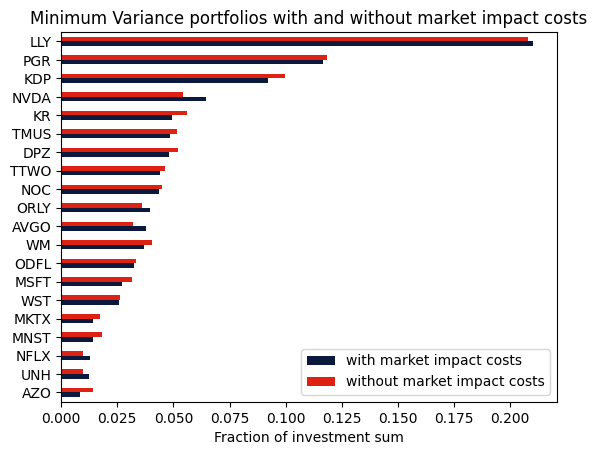

In [13]:
# remove budget constraint
m.remove(budget_constr)
# add new budget constraint without costs
m.addConstr(x.sum() == 1, name="Budget_Constraint")
m.params.OutputFlag = 0
m.optimize()

# retrieve and display solution data
positions_no_costs = pd.Series(name="Position", data=x.X, index=mu.index)
mask = (df["position"] > 1e-5) | (positions_no_costs > 1e-5)
df2 = pd.DataFrame(
    index=df[mask].index,
    data={
        "with market impact costs": df["position"],
        "without market impact costs": positions_no_costs,
    },
).sort_values("with market impact costs", ascending=True)

axs = df2.plot.barh(color=["#0b1a3c", "#dd2113"])
axs.set_xlabel("Fraction of investment sum")
plt.title("Minimum Variance portfolios with and without market impact costs")
plt.show()

## Takeaways
* Market impact costs with the power $\frac32$ can be modeled using quadratic constraints.
* Minimum transaction sizes in combination with market impact costs make this a combinatorial problem.

## Literature

[1] Grinold R.C., Kahn R.N. 2000. Active Portfolio Management. McGraw-Hill, New York, Second Edition.

[2] Ben-Tal A. and Nemirovski A. 2001. Lectures on Modern Convex Optimization. SIAM.